<a href="https://colab.research.google.com/github/doaa23-1/machine-learning-projects/blob/main/credit_risk_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Decision Support System for Energy Project Financing


1. Business Problem & Objective

Financial institutions that finance energy and infrastructure projects face significant credit risk, as project failure or delayed repayments can lead to substantial financial losses. Traditional credit assessment methods often rely on manual evaluation and rigid rules, which may not fully capture complex risk patterns within project financing data.

The objective of this project is to develop a credit risk decision support system that leverages data analytics and machine learning to assess the probability of default for financing applications. Instead of producing a simple approval or rejection outcome, the system translates predictive insights into actionable risk scores and financing recommendations.

This system aims to support decision-makers by improving risk visibility, enabling consistent financing decisions, and enhancing governance and risk management practices within energy-focused financial institutions.

##Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

##Data Loading

In [4]:
train_df = pd.read_csv('/content/train_u6lujuX_CVtuZ9i.csv')
test_df = pd.read_csv('/content/test_Y3wMUE5_7gLdaTN.csv')

##Initial Exploration

In [5]:
print("First 5 rows of TRAIN dataset:")
display(train_df.head())

print("\nFirst 5 rows of TEST dataset:")
display(test_df.head())

First 5 rows of TRAIN dataset:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y



First 5 rows of TEST dataset:


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [6]:
# Dataset shape
print("Train dataset shape (rows, columns):", train_df.shape)
print("Test dataset shape  (rows, columns):", test_df.shape)

# Dataset Info (Clean Summary)
print("\nTrain dataset info:")
train_df.info()
print("\nTest dataset info:")
test_df.info()

Train dataset shape (rows, columns): (614, 13)
Test dataset shape  (rows, columns): (367, 12)

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ 

In [7]:
# Target variable distribution
train_df['Loan_Status'].value_counts()

,count
Loan_Status,
Y,422
N,192


The dataset contains historical financing applications, where each record represents a financing request for a project. The target variable indicates whether the financing was approved or rejected, which serves as a proxy for credit risk assessment.

##Missing Value Treatment

In [8]:
print(train_df.columns)
print(test_df.columns)


Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


In [9]:
# Train missing values count
train_df.isnull().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [10]:
# Test missing values count
test_df.isnull().sum()

,0
Loan_ID,0
Gender,11
Married,0
Dependents,10
Education,0
Self_Employed,23
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,5
Loan_Amount_Term,6


In [11]:
numeric_cols = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed']

In [12]:
# Train data
for col in numeric_cols:
    train_df[col] = train_df[col].fillna(train_df[col].median())

for col in categorical_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

Median imputation was used for numerical variables to reduce the impact of outliers commonly observed in financial data.

In [13]:
# Test data (use TRAIN statistics → avoid data leakage)
for col in numeric_cols:
    test_df[col] = test_df[col].fillna(train_df[col].median())

for col in categorical_cols:
    test_df[col] = test_df[col].fillna(train_df[col].mode()[0])

To ensure consistency and avoid data leakage, missing values in the test dataset were imputed using statistics derived from the training data.

In [14]:
train_df.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [15]:
test_df.isnull().sum()

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


##Feature Engineering

Total Income

In [16]:
train_df['Total_Income'] = train_df['ApplicantIncome'] + train_df['CoapplicantIncome']
test_df['Total_Income'] = test_df['ApplicantIncome'] + test_df['CoapplicantIncome']

Loan to Income Ratio

> This ratio reflects the applicant’s repayment capacity relative to the requested financing amount.



In [17]:
train_df['Loan_to_Income_Ratio'] = train_df['LoanAmount'] / train_df['Total_Income']
test_df['Loan_to_Income_Ratio'] = test_df['LoanAmount'] / test_df['Total_Income']

Indicators
> Education → Graduate Indicator



In [18]:
train_df['Graduate_Flag'] = train_df['Education'].apply(lambda x: 1 if x == 'Graduate' else 0)
test_df['Graduate_Flag'] = test_df['Education'].apply(lambda x: 1 if x == 'Graduate' else 0)



> Self Employed → Risk Indicator



In [19]:
train_df['Self_Employed_Flag'] = train_df['Self_Employed'].apply(lambda x: 1 if x == 'Yes' else 0)
test_df['Self_Employed_Flag'] = test_df['Self_Employed'].apply(lambda x: 1 if x == 'Yes' else 0)

Credit History Flag

In [20]:
train_df['Good_Credit_History'] = train_df['Credit_History'].apply(lambda x: 1 if x == 1 else 0)
test_df['Good_Credit_History'] = test_df['Credit_History'].apply(lambda x: 1 if x == 1 else 0)

Drop non-essential columns

In [21]:
drop_cols = ['Loan_ID', 'Education', 'Self_Employed']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

In [ ]:
train_df.head()

,Gender,Married,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Loan_to_Income_Ratio,Graduate_Flag,Self_Employed_Flag,Good_Credit_History
0,Male,No,0,5849,0.0,128.0,360.0,1.0,Urban,Y,5849.0,0.021884,1,0,1
1,Male,Yes,1,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.021015,1,0,1
2,Male,Yes,0,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.022000,1,1,1
3,Male,Yes,0,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.024287,0,0,1
4,Male,No,0,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.023500,1,0,1


## Encoding + Target Transformation

In [22]:
train_df['Loan_Status'] = train_df['Loan_Status'].map({'Y': 1, 'N': 0})

In [23]:
X = train_df.drop('Loan_Status', axis=1)
y = train_df['Loan_Status']

In [24]:
X_encoded = pd.get_dummies(X, drop_first=True)
test_encoded = pd.get_dummies(test_df, drop_first=True)

In [25]:
X_encoded, test_encoded = X_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

In [26]:
X_encoded.shape, test_encoded.shape

((614, 17), (367, 17))

## Model: Logistic Regression

**Model Selection Rationale:
Logistic Regression was intentionally selected due to its high interpretability, which is essential in credit risk and decision support systems.
The objective of this project prioritizes transparency, explainability, and governance alignment over purely maximizing predictive accuracy.**


Train / Validation Split

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

Scaling

In [28]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

Model Training

In [29]:
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

Model Evaluation

In [30]:
y_val_pred  = log_model.predict(X_val_scaled)
y_val_proba = log_model.predict_proba(X_val_scaled)[:, 1]

print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))

[[22 16]
 [ 1 84]]
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

ROC-AUC: 0.874922600619195


**Note on Class Imbalance:
The dataset exhibits moderate class imbalance (~69% approvals vs 31% rejections).
ROC-AUC was therefore used as a key evaluation metric to ensure balanced performance beyond simple accuracy.**

##Feature Importance

Feature scaling was applied while preserving feature names to ensure interpretability and transparent risk analysis.

In [31]:
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': log_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

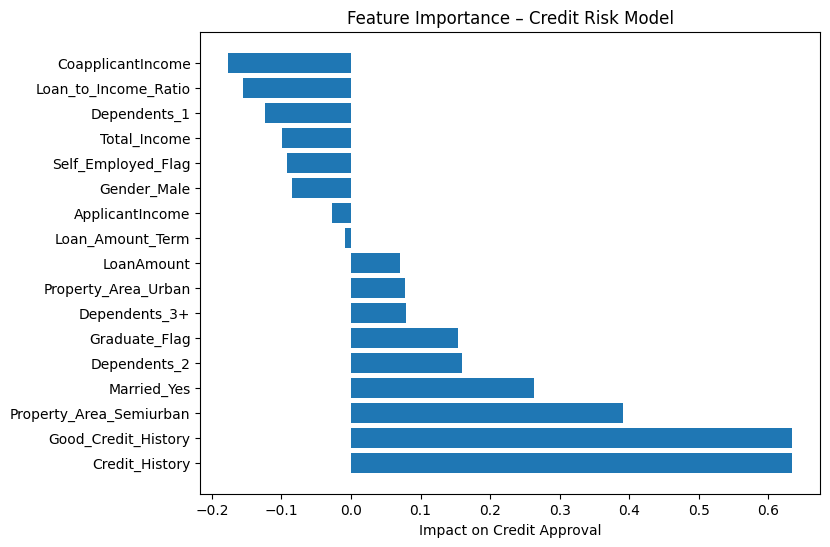

In [32]:
plt.figure(figsize=(8,6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.title("Feature Importance – Credit Risk Model")
plt.xlabel("Impact on Credit Approval")
plt.show()

##Convert Model to Risk Score

In [42]:
train_results = X_train.copy()

# Probability of Rejection (Credit Risk)
train_results['Probability_of_Rejection'] = log_model.predict_proba(X_train_scaled)[:, 0]

# Risk Score (0–100)
train_results['Risk_Score'] = (
    train_results['Probability_of_Rejection'] * 100
).round(1)

In [43]:
train_results.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Loan_to_Income_Ratio,Graduate_Flag,Self_Employed_Flag,Good_Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban,Probability_of_Rejection,Risk_Score
154,3254,0.0,50.0,360.0,1.0,3254.0,0.015366,1,0,1,True,False,False,False,False,False,True,0.256239,25.6
239,3315,0.0,96.0,360.0,1.0,3315.0,0.028959,1,0,1,True,True,True,False,False,True,False,0.152411,15.2
448,3340,1710.0,150.0,360.0,0.0,5050.0,0.029703,1,0,0,True,True,False,True,False,False,False,0.894809,89.5
471,2653,1500.0,113.0,180.0,0.0,4153.0,0.027209,0,0,0,True,True,True,False,False,False,False,0.960259,96.0
273,2620,2223.0,150.0,360.0,1.0,4843.0,0.030973,1,0,1,True,True,False,False,False,True,False,0.131620,13.2


**Decision Layer:
Model probabilities are translated into actionable financing decisions using predefined risk thresholds to support consistent and explainable decisions.**

In [34]:
def decision_rule(score):
    if score < 30:
        return "Approve – Low Risk"
    elif score < 60:
        return "Conditional Approval"
    else:
        return "Reject – High Risk"

train_results['Decision'] = train_results['Risk_Score'].apply(decision_rule)

In [35]:
train_results.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Loan_to_Income_Ratio,Graduate_Flag,Self_Employed_Flag,Good_Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Semiurban,Property_Area_Urban,Default_Probability,Risk_Score,Decision
154,3254,0.0,50.0,360.0,1.0,3254.0,0.015366,1,0,1,True,False,False,False,False,False,True,0.256239,25.6,Approve – Low Risk
239,3315,0.0,96.0,360.0,1.0,3315.0,0.028959,1,0,1,True,True,True,False,False,True,False,0.152411,15.2,Approve – Low Risk
448,3340,1710.0,150.0,360.0,0.0,5050.0,0.029703,1,0,0,True,True,False,True,False,False,False,0.894809,89.5,Reject – High Risk
471,2653,1500.0,113.0,180.0,0.0,4153.0,0.027209,0,0,0,True,True,True,False,False,False,False,0.960259,96.0,Reject – High Risk
273,2620,2223.0,150.0,360.0,1.0,4843.0,0.030973,1,0,1,True,True,False,False,False,True,False,0.131620,13.2,Approve – Low Risk


In [36]:
train_results[['Risk_Score', 'Decision']].value_counts()

,,count
Risk_Score,Decision,
10.4,Approve – Low Risk,6
27.8,Approve – Low Risk,5
13.0,Approve – Low Risk,5
17.1,Approve – Low Risk,5
15.8,Approve – Low Risk,5
...,...,...
92.4,Reject – High Risk,1
92.6,Reject – High Risk,1
96.0,Reject – High Risk,1


In [44]:
# Final Evaluation on Test Data (Simulation of Real-World Deployment)

test_scaled = pd.DataFrame(
    scaler.transform(test_encoded),
    columns=test_encoded.columns,
    index=test_encoded.index
)

test_results = test_df.copy()

test_results['Probability_of_Rejection'] = log_model.predict_proba(test_scaled)[:, 0]
test_results['Risk_Score'] = (test_results['Probability_of_Rejection'] * 100).round(1)

test_results['Decision'] = test_results['Risk_Score'].apply(decision_rule)

test_results.head()


,Gender,Married,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Loan_to_Income_Ratio,Graduate_Flag,Self_Employed_Flag,Good_Credit_History,Probability_of_Rejection,Risk_Score,Decision
0,Male,Yes,0,5720,0,110.0,360.0,1.0,Urban,5720,0.019231,1,0,1,0.175328,17.5,Approve – Low Risk
1,Male,Yes,1,3076,1500,126.0,360.0,1.0,Urban,4576,0.027535,1,0,1,0.266759,26.7,Approve – Low Risk
2,Male,Yes,2,5000,1800,208.0,360.0,1.0,Urban,6800,0.030588,1,0,1,0.153218,15.3,Approve – Low Risk
3,Male,Yes,2,2340,2546,100.0,360.0,1.0,Urban,4886,0.020467,1,0,1,0.141102,14.1,Approve – Low Risk
4,Male,No,0,3276,0,78.0,360.0,1.0,Urban,3276,0.023810,0,0,1,0.363437,36.3,Conditional Approval


In [45]:
# Export final decision table
test_results.to_csv("credit_risk_decisions.csv", index=False)

## What-If Analysis

**What-if Analysis:**

Simulates policy and financial changes to assess sensitivity of credit risk


###Scenario 1: increase LoanAmount 20%

In [39]:
scenario = X_train.copy()
scenario['LoanAmount'] *= 1.2

scenario_scaled = pd.DataFrame(
    scaler.transform(scenario),
    columns=scenario.columns,
    index=scenario.index
)

scenario['New_Risk_Score'] = (
    log_model.predict_proba(scenario_scaled)[:, 0] * 100
).round(1)

scenario[['New_Risk_Score']].head()

,New_Risk_Score
154,25.5
239,15.0
448,89.2
471,96.0
273,12.9


###Scenario 2: improve ApplicantIncome 15%

In [38]:
scenario_income = X_train.copy()
scenario_income['ApplicantIncome'] *= 1.15

scenario_income_scaled = pd.DataFrame(
    scaler.transform(scenario_income),
    columns=scenario_income.columns,
    index=scenario_income.index
)

scenario_income['New_Risk_Score'] = (
    log_model.predict_proba(scenario_income_scaled)[:, 0] * 100
).round(1)

**Limitations & Future Enhancements:**
- Future work may include benchmarking against tree-based models (e.g., Random Forest, XGBoost) to compare performance.

- Class imbalance handling techniques such as class weighting or resampling could be explored to enhance minority class sensitivity.

- Threshold optimization may be applied to align decisions with institutional risk appetite.